## Movie Recomendations System

We use libraries like Pandas and numpy for the data manipulation, matplotlib for the plots and PCA and Hierarchy for optimizations on the data representation

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy

First we read the csv and create a new matrix to store the evaluations

In [54]:
dfmovies = pd.read_csv('../movies/movies_description.txt',sep='|',header=None)
dfusers = pd.read_csv('../movies/users_description.txt',sep='|',header=None)
dfscores = pd.read_csv('../movies/movies_users.txt',sep='\t',header=None)

nusers = len(dfusers.values)
nmovies = len(dfmovies.values)

evaluations = np.zeros((nmovies,nusers))
evaluations[ dfscores.values[:,1]-1, dfscores.values[:,0]-1 ] = dfscores.values[:,2]
dfevaluations = pd.DataFrame(evaluations,index=dfmovies.values[:,1],columns=np.arange(nusers)+1)

tmovies = list(dfevaluations.index)
idusers = dfevaluations.columns
for i in range(nmovies):
    tmovies[i] = str(tmovies[i]).split('(')[0]
tmovies = np.array(tmovies)

Then we filter the movies taking the more representative evaluated movies with their corresponding evaluators

In [55]:
# Filtering movies

bevaluations = evaluations!=0
nmovies = 500
nusers = 120

neval = np.sum( bevaluations, axis=1 )
idx = np.argsort(neval)[::-1]
idx = idx[:nmovies]

evaluations = evaluations[idx,:]
tmovies = tmovies[idx]

neval = np.sum( bevaluations, axis=0 )
idx = np.argsort(neval)[::-1]
idx = idx[:nusers]

evaluations = evaluations[:, idx]
idusers = idusers[idx]

After taking the more representative movies, we need to fix those evaluations where the user hadn't watch the movie yet. 

For this we use a simple algorithm to fill those places.

1.- Create a new empty matrix

2.- For each movie, we are going to traverse for all the other movies and check the simillitudes between the user evaluation's. We calculate the number of evaluations with the same rating and sort each movie corresponding with this number.

3.- After having this order, we are going to traverse again all the movies but in the sorted order starting from the most similar evaluated movie to the less similar. For each movie we calculate the probability of using this movie as a 'filling', where, if selected, we take the user evaluation for the other movie and use it for our selected movie to fill that unrated position.

4.- After doing this process for all the movies, if there is still an unrated position, we calculate the average of the ratings and set that position with that values.

This assigments are based on the following arguments. When you haven't watch a movie, you ask to a person with the same preferences on movies to tell you how good is that movie. In the end, if none of the people you ask for knows that movie, you simply go to specialized webpages with lots of information, where the average normally tells the acceptance of that movie for the public in general.

This is why it is important to first check with other users with same preferences before looking for the general average rating.

In [56]:
aux = evaluations
best = np.zeros((nmovies,nusers))
for i in range(nmovies):
    cosas, m = [ [] for _ in range(0,nusers+1)], 0
    for j in range(nmovies):
        if i == j: continue
        a = aux[i,:]    
        b = aux[j,:]

        x = a==b
        a = a[x]
        x = a != 0
        a = a[x]
        m = max(m, a.size) 
        cosas[a.size].append(j)

    for midx in range(m,0,-1):
        if len(cosas[midx]) > 0 and np.random.uniform() < 0.8:
            muestra = cosas[midx][np.random.randint(len(cosas[midx]))]
            
            a = aux[i,:]    
            b = aux[muestra,:]
            idx  = b != 0
            idx2 = a == 0
            idx = np.logical_and(idx, idx2)
            a[idx] = b[idx]
            best[i] = a

for i in range(nmovies):
     a = best[i, :]
     idx = a != 0
     k = np.sum(idx)
     val = np.sum(a[idx]) / k
     idx2 = a == 0
     best[i, idx2] = np.rint(val)

In [57]:
dfbest = pd.DataFrame(best, index=tmovies) #, columns=idusers)
dfbest

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
Star Wars,5.0,4.0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,5.0,...,4.0,4.0,3.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0
Contact,5.0,2.0,4.0,4.0,5.0,5.0,4.0,4.0,2.0,4.0,...,5.0,3.0,4.0,5.0,4.0,5.0,4.0,4.0,2.0,1.0
Fargo,4.0,3.0,5.0,4.0,5.0,5.0,4.0,5.0,4.0,1.0,...,5.0,2.0,2.0,5.0,5.0,5.0,4.0,1.0,3.0,1.0
Return of the Jedi,5.0,3.0,5.0,4.0,5.0,5.0,2.0,5.0,3.0,4.0,...,4.0,4.0,3.0,5.0,3.0,4.0,3.0,5.0,4.0,3.0
Liar Liar,5.0,3.0,2.0,4.0,4.0,4.0,1.0,4.0,3.0,4.0,...,4.0,2.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Shallow Grave,1.0,4.0,3.0,3.0,3.0,5.0,3.0,4.0,3.0,4.0,...,4.0,3.0,5.0,4.0,4.0,5.0,4.0,4.0,2.0,2.0
Tommy Boy,1.0,2.0,2.0,2.0,3.0,4.0,1.0,4.0,1.0,4.0,...,3.0,2.0,3.0,1.0,3.0,4.0,3.0,3.0,2.0,1.0
In the Company of Men,1.0,5.0,4.0,4.0,4.0,3.0,5.0,5.0,3.0,4.0,...,4.0,1.0,3.0,5.0,5.0,5.0,3.0,5.0,3.0,3.0
Diva,1.0,3.0,4.0,4.0,4.0,4.0,3.0,5.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,4.0,5.0,4.0,2.0,2.0


After having our completly filled data, we use the Principal Component Analysis to select those data who workks the best for our model. Then we plot for a better compression of how is it working.

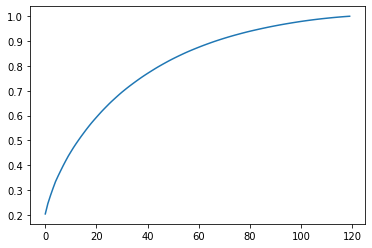

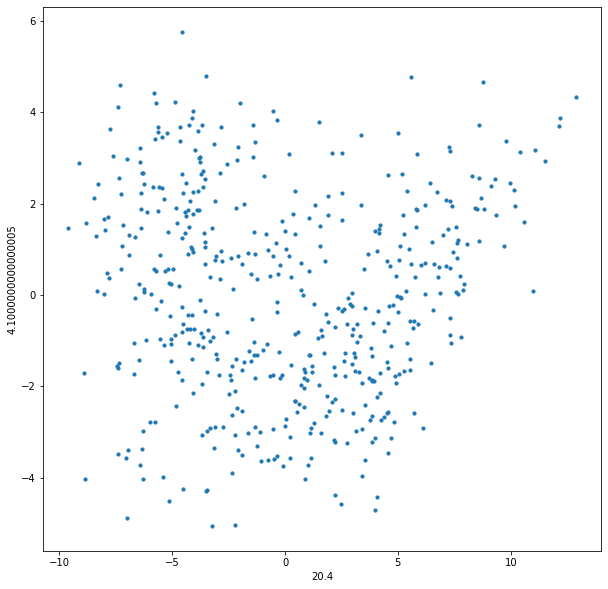

In [58]:
X = best
n = len(X)
model = PCA()
model.fit(X)
X2 = model.transform(X)
X_PCA = X2
X2 = X2[:,:2]
exp_var = model.explained_variance_ratio_
exp_var_acum = np.cumsum(exp_var)
plt.figure()
plt.plot(exp_var_acum)
plt.show()
plt.figure(figsize=(10,10))
plt.scatter(X2[:,0],X2[:,1],s=10, cmap='inferno')
plt.xlabel(np.round(exp_var[0],3)*100)
plt.ylabel(np.round(exp_var[1],3)*100)
plt.show()

After having our data processed, the we run Hierarchy to cluster our data points. The following diagram show us how are the values distributed and the distances differences between those points.

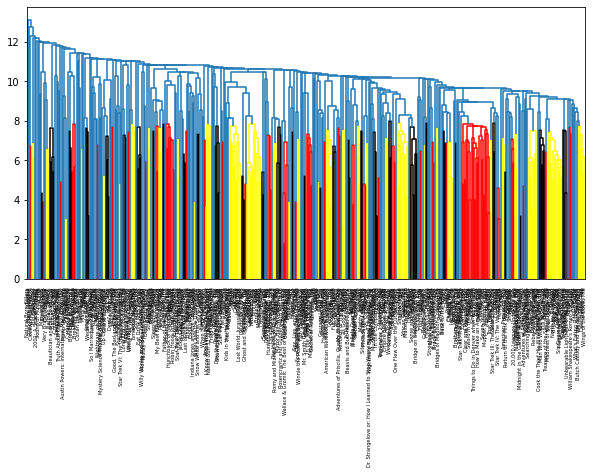

In [59]:
hierarchy.set_link_color_palette(['red','yellow', 'black'])

plt.figure(figsize=(10,5))
Z = hierarchy.linkage(X_PCA)
dn = hierarchy.dendrogram(Z, labels=tmovies, color_threshold=8.0)
plt.show()

After having our data we run the following algorithm.

For each movie recommendation we want to calculate , we cheack the hierarchy distance starting from a small one, and incement this distance until we cluster in a group with enough movies to select a not repetead movie. This helps us to don't select repeated movies, and the step asserts that our selection will be closer to our movie preferences.

In [60]:
def getGroupWithDistance(id, dist=5.0):
    g = hierarchy.fcluster(Z,criterion='distance',t=dist)
    grupo = g[id]
    idx = g == grupo
    return tmovies[idx], idx

def printMovieIndexes():
    for i,evaluation in enumerate(tmovies):
        print(f'ID - {i}   Movie - \'{evaluation}\'')

def getRecommendation(index):
    new_index = []
    movie_names = tmovies[index]
    print("Your choosed movies are:",movie_names)
    for movie_name, x in zip(movie_names, index):
        dist = 5.0
        group, filtered_group = 0, [] 
        while len(filtered_group) < 1:
            group, idx = getGroupWithDistance(x, dist) 
            dist += 0.05
            filter = group != movie_name
            for movie_n in movie_names:
                filter = np.logical_and(filter, group != movie_n)
            for movie_n in new_index:
                filter = np.logical_and(filter, group != movie_n)
            filtered_group = group[filter] 
        recommendation = np.random.choice(filtered_group)
        new_index.append( recommendation )
        print(f'The recommendation for \'{movie_name}\' it\'s: \'{recommendation}\'') # , dist)
    return new_index

def MovieRecommendations():
    ids = np.array([int(x) for x in input(print("Give me 5 movie id's: ")).split(' ') if x ])
    assert len(ids) == 5, "You must write exactly 5 ids"
    assert (np.min(ids) >= 0 and np.max(ids) < nmovies), f"The id's should be between 0 and {nmovies-1}"
    recommendations = getRecommendation(ids)

## Ejectution

In [61]:
printMovieIndexes()

ID - 0   Movie - 'Star Wars '
ID - 1   Movie - 'Contact '
ID - 2   Movie - 'Fargo '
ID - 3   Movie - 'Return of the Jedi '
ID - 4   Movie - 'Liar Liar '
ID - 5   Movie - 'English Patient, The '
ID - 6   Movie - 'Scream '
ID - 7   Movie - 'Toy Story '
ID - 8   Movie - 'Air Force One '
ID - 9   Movie - 'Independence Day '
ID - 10   Movie - 'Raiders of the Lost Ark '
ID - 11   Movie - 'Godfather, The '
ID - 12   Movie - 'Pulp Fiction '
ID - 13   Movie - 'Twelve Monkeys '
ID - 14   Movie - 'Silence of the Lambs, The '
ID - 15   Movie - 'Jerry Maguire '
ID - 16   Movie - 'Rock, The '
ID - 17   Movie - 'Empire Strikes Back, The '
ID - 18   Movie - 'Star Trek: First Contact '
ID - 19   Movie - 'Titanic '
ID - 20   Movie - 'Back to the Future '
ID - 21   Movie - 'Mission: Impossible '
ID - 22   Movie - 'Fugitive, The '
ID - 23   Movie - 'Indiana Jones and the Last Crusade '
ID - 24   Movie - 'Willy Wonka and the Chocolate Factory '
ID - 25   Movie - 'Princess Bride, The '
ID - 26   Movie - 'Fo

In [62]:
getRecommendation([74, 88, 96, 114, 116, 159, 181, 218, 279, 300, 315, 18, 43, 327, 270 , 273, 309])

Your choosed movies are: ['Casablanca ' 'Heat ' 'Aladdin ' 'Beauty and the Beast ' 'Batman '
 'Star Trek III: The Search for Spock ' 'Kingpin ' 'Batman Returns '
 'Carrie ' 'Batman Forever ' 'Scream 2 ' 'Star Trek: First Contact '
 'Alien ' 'Sex, Lies, and Videotape ' 'Alien: Resurrection '
 'Bonnie and Clyde ' '101 Dalmatians ']
The recommendation for 'Casablanca ' it's: 'Maltese Falcon, The '
The recommendation for 'Heat ' it's: 'Indiana Jones and the Last Crusade '
The recommendation for 'Aladdin ' it's: 'Lion King, The '
The recommendation for 'Beauty and the Beast ' it's: 'Like Water For Chocolate '
The recommendation for 'Batman ' it's: 'Jungle Book, The '
The recommendation for 'Star Trek III: The Search for Spock ' it's: 'City Hall '
The recommendation for 'Kingpin ' it's: 'Happy Gilmore '
The recommendation for 'Batman Returns ' it's: 'Beautician and the Beast, The '
The recommendation for 'Carrie ' it's: 'Butch Cassidy and the Sundance Kid '
The recommendation for 'Batman For

['Maltese Falcon, The ',
 'Indiana Jones and the Last Crusade ',
 'Lion King, The ',
 'Like Water For Chocolate ',
 'Jungle Book, The ',
 'City Hall ',
 'Happy Gilmore ',
 'Beautician and the Beast, The ',
 'Butch Cassidy and the Sundance Kid ',
 'Jack ',
 'Beavis and Butt-head Do America ',
 'Picture Perfect ',
 'Aliens ',
 'Diva ',
 'Mars Attacks! ',
 'Rebel Without a Cause ',
 'Parent Trap, The ']

In [64]:
recommendations = getRecommendation([45, 43])
# MovieRecommendations()

Your choosed movies are: ['Aliens ' 'Alien ']
The recommendation for 'Aliens ' it's: 'Patton '
The recommendation for 'Alien ' it's: 'Bram Stoker's Dracula '
